Let's build an MNIST image recognition model using the saved functions. Goal is to get used to the callback system built in class

In [38]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import torch.nn.functional as F
import matplotlib.pyplot as plt

from exp.nb import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [5]:
import torch
from torchvision import datasets, transforms

# Transform to convert images to PyTorch tensors
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the training data
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

print('Length of train and test set', len(trainset), len(testset))

Length of train and test set 60000 10000


In [42]:
nh, bs = 50, 64
loss_func = F.cross_entropy

train_ds = Dataset(trainset.data.float().div_(255), F.one_hot(trainset.targets, 10))
valid_ds = Dataset(testset.data.float().div_(255), F.one_hot(testset.targets, 10))
data = DataBunch(*get_dls(train_ds, valid_ds, bs), 10)


## Visualizing data

In [46]:
images, labels = next(iter(trainloader))

In [48]:
images[0].dtype, labels[0].dtype

(torch.float32, torch.int64)

In [55]:
images[0].max()

tensor(1.)

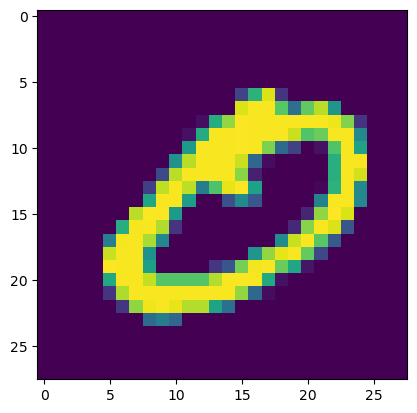

In [14]:
plt.imshow(images[2].view(28, 28))

In [16]:
labels[2]

tensor(0)

## Basic model

using a simple architecture with 2 fully connected layers

In [8]:
learn= Learner(*get_model(data), loss_func=F.cross_entropy, data=data)

In [84]:
def fit(epochs, learn):
    for epoch in range(epochs):
        learn.model.train()
        for xb,yb in learn.data.train_dl:
            loss = learn.loss_func(learn.model(xb), yb)
            loss.backward()
            learn.opt.step()
            learn.opt.zero_grad()

        learn.model.eval()
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in learn.data.valid_dl:
                pred = learn.model(xb)
                tot_loss += learn.loss_func(pred, yb)
                tot_acc  += accuracy(pred,yb)
        nv = len(learn.data.valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [87]:
loss,acc = fit(1, learn)

0 tensor(2.1107) tensor(0.9000)


## Callbacks

### V1

In [47]:
def one_batch(xb, yb, cbh):
    """given a batch and callback handler"""
    if not cbh.begin_batch(xb, yb): return
    loss = cbh.learn.loss_func(cbh.learn.model(xb), yb)
    if not cbh.after_loss(loss): return
    loss.backward()
    if cbh.after_backward(): cbh.learn.opt.step()
    if cbh.after_step(): cbh.learn.opt.zero_grad()

def all_batches(dl, cbh):
    print('all_batches, cbh.learn.stop is ', cbh.learn.stop)
    for xb,yb in dl:
        one_batch(xb, yb, cbh)
        if cbh.do_stop():
            print('cbh.learn.stop is', cbh.learn.stop) 
            return

def fit(epochs, learn, cbh):
    if not cbh.begin_fit(learn): return
    for epoch in range(epochs):
        if not cbh.begin_epoch(epoch): continue
        print('fitting')
        all_batches(learn.data.train_dl, cbh)

        if cbh.begin_validate():
            with torch.no_grad():
                print('validating, cbh.learn.stop is ', cbh.learn.stop)
                all_batches(learn.data.valid_dl, cbh)
        if cbh.do_stop() or not cbh.after_epoch(): break
    cbh.after_fit()


In [37]:
class Callback():
    def begin_fit(self, learn):
        self.learn = learn
        return True
    def after_fit(self): return True
    def begin_epoch(self, epoch):
        self.epoch=epoch
        return True
    def begin_validate(self): return True
    def after_epoch(self): return True
    def begin_batch(self, xb, yb):
        self.xb, self.yb = xb, yb
        return True
    def after_loss(self, loss):
        self.loss = loss
        return True
    def after_backward(self): return True
    def after_step(self): return True

In [64]:
class CallbackHandler():
    def __init__(self, cbs=None):
        self.cbs = cbs if cbs else []

    def begin_fit(self, learn):
        print('begin fit is called!!')
        self.learn, self.in_train = learn, True
        learn.stop = False
        res = True
        for cb in self.cbs: res = res and cb.begin_fit(learn)
        return res # if any of the callbacks return False, stop
    
    def after_fit(self):
        res = not self.in_train # if we didn't do training, don't do validation
        for cb in self.cbs: res = res and cb.after_fit()
        return res

    def begin_epoch(self, epoch):
        self.learn.model.train()
        self.in_train = True
        res = True
        for cb in self.cbs: res = res and cb.begin_epoch(epoch)
        return res

    def begin_validate(self):
        self.learn.model.eval()
        self.in_train=False
        res = True
        for cb in self.cbs: res = res and cb.begin_validate()
        return res

    def after_epoch(self):
        res = True
        for cb in self.cbs: res = res and cb.after_epoch()
        return res
    
    def begin_batch(self, xb, yb):
        res = True
        for cb in self.cbs: res = res and cb.begin_batch(xb, yb)
        return res

    def after_loss(self, loss):
        res = self.in_train
        for cb in self.cbs: res = res and cb.after_loss(loss)
        return res

    def after_backward(self):
        res = True
        for cb in self.cbs: res = res and cb.after_backward()
        return res

    def after_step(self):
        res = True
        for cb in self.cbs: res = res and cb.after_step()
        return res
    
    def do_stop(self):
        try:  
            print('inside do_stop', self.learn.stop, 'id is', 'none' if not hasattr(self.learn, 'id') else self.learn.id)   
            return self.learn.stop # stop if there is signal to stop from self.learn
        finally: pass#self.learn.stop = False # the stop signal does not persist to the next all_batches
        

In [54]:
class Testcallback(Callback):
    def begin_fit(self, learn):
        super().begin_fit(learn)
        self.n_iters = 0
        return True

    def begin_batch(self, xb, yb):
        super().begin_batch(xb, yb)
        print('batch', self.n_iters)
        return True 

    def after_step(self):
        self.n_iters += 1
        #print(self.n_iters)
        if self.n_iters > 10: 
            self.learn.id = 3
            self.learn.stop = True
        return True 

In [65]:
fit(1, learn, cbh=CallbackHandler([Testcallback()]))

begin fit is called!!
fitting
all_batches, cbh.learn.stop is  False
batch 0
inside do_stop False id is 3
batch 1
inside do_stop False id is 3
batch 2
inside do_stop False id is 3
batch 3
inside do_stop False id is 3
batch 4
inside do_stop False id is 3
batch 5
inside do_stop False id is 3
batch 6
inside do_stop False id is 3
batch 7
inside do_stop False id is 3
batch 8
inside do_stop False id is 3
batch 9
inside do_stop False id is 3
batch 10
inside do_stop True id is 3
cbh.learn.stop is True
validating, cbh.learn.stop is  True
all_batches, cbh.learn.stop is  True
batch 11
inside do_stop True id is 3
cbh.learn.stop is True
inside do_stop True id is 3


this code is very hard to debug, there are 3 classes modifying each other and store the other as attribute

also the callback trigger was called from inside training loop, making it even more complicated

### Improved callbacks

we combine the training loop function with the callback handler into the same object called Runner. Runner accepts a list of callbacks when initializing

callback is its own object, it gets passed the runner object when needed

In [39]:
learn = Learner(*get_model(data), loss_func, data)

In [40]:
stats = AvgStatsCallback(['accuracy'], [accuracy])
run = Runner(cbs=stats)

In [41]:
run.fit(2, learn)

train: loss 2.14, accuracy 0.90
valid: loss 2.11, accuracy 0.90
train: loss 2.11, accuracy 0.90
valid: loss 2.11, accuracy 0.90


- We improved the AvgStatsCallback from Jeremy's version by printing also the name of the metrics being avg and printed
- AngStatsCallback shows the running average of all the metrics it was asked to keep track of, including loss by default

## Anneal